In [11]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import camb
from pybird import pybird

Some aesthetic definitions for the plots

In [12]:
font = {'size': 16, 'family': 'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

## Linear power spectrum

Instantiate a Class object, set parameters and compute

In [13]:
zpk = 0.5
pars = camb.CAMBparams()
pars.InitPower.set_params(As=np.exp(3.044)/1.0e10, ns=0.9649)
pars.set_matter_power(redshifts=[zpk, 0.0001], kmax=1.0)
pars.set_cosmology(H0=67.36, omch2=0.120, ombh2=0.02237)
pars.NonLinear = camb.model.NonLinear_none
results = camb.get_results(pars)
kk, _, Pin = results.get_matter_power_spectrum(minkh=2.0e-5, maxkh=1.0, npoints=2000)
Pk = Pin[-1]

Get the linear power spectrum at redshift zpk, and plot it

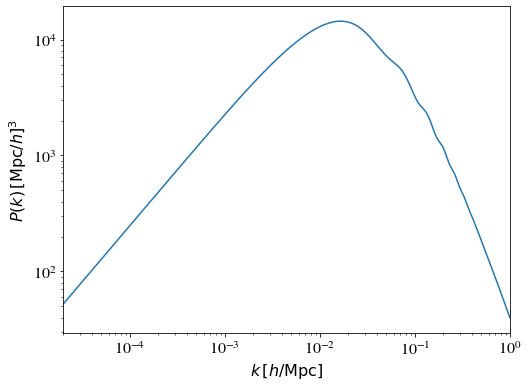

In [14]:
plt.figure()

plt.plot(kk, Pk, 'C0-')

plt.xscale('log')
plt.yscale('log')

plt.xlim(kk[0], kk[-1])

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

## Loading PyBird

Define a vector with the bias parameters bs = [b1, b2, b3, b4, cct, cr1, cr2]

In [15]:
bs = [2., 0.8, 0.2, 0.8, 0.2, -4., 0]

Define an object of the class Common, with settings for the pybird objects. 

In particular, choose the kmax (in h/Mpc) up to which to compute the nonlinear power spectrum and the number of multipoles Nl (2 or 3) to evaluate.

In [16]:
kmax = 0.3
common = pybird.Common(Nl=2, kmax=kmax, optiresum=True)

Instantiate the class that calculates the nonlinear power spectrum.
It will load precomputed FFTLog matrices if they are in the folder, otherwise it will compute new ones.

In [17]:
import time

In [18]:
time1 = time.time()
nonlinear = pybird.NonLinear(load=True, save=True, co=common)
print(time.time() - time1)

Can't load loop matrices at ./. 
 Computing new matrices.
10.225661993026733


Instantiate the class that calculates the resummed power spectrum

In [19]:
resum = pybird.Resum(co=common)

Finally, instantiate the class that applies the Alcock-Paczynski (AP) effect, the window function, the fiber collisions, and interpolate on the data kbins

In [20]:
kdata = np.linspace(0.005, 0.25, 50)
Om_AP = 0.31
z_AP = zpk

In [38]:
projection = pybird.Projection(kdata, pybird.DA(Om_AP, z_AP), pybird.Hubble(Om_AP, z_AP), co=common)

## Nonlinear power spectrum

Now instantiate the main class

In [39]:
DA = results.angular_diameter_distance(zpk) * 67.36 / 299792.458
H = results.hubble_parameter(zpk) / 67.36
fsigma8 = results.get_fsigma8()[0]
sigma8 = results.get_sigma8()[0]
f = fsigma8/sigma8

bird = pybird.Bird(kk, Pk, f, DA, H, zpk, which='full', co=common)

Call the routine to get the power spectrum (and correlation function), and compute it in the bird object. The correlation function is useful for the IR-resummation.

In [40]:
time1 = time.time()
nonlinear.PsCf(bird)
bird.setPsCf(bs)
print(time.time()-time1)

bird.setfullPs()
noresumPs = np.copy(bird.fullPs)

0.10676407814025879


Compute the resummed power spectrum

In [41]:
time1 = time.time()
resum.Ps(bird)
print(time.time() - time1)

resumPs = np.copy(bird.fullPs)

0.18800902366638184


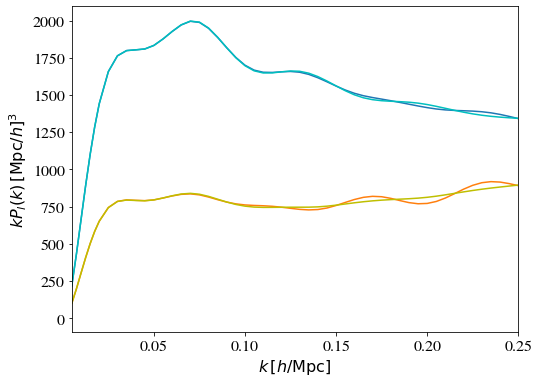

In [42]:
plt.figure()

plt.plot(common.k, common.k * noresumPs[0], 'C0-', label = 'mono noresum')
plt.plot(common.k, common.k * noresumPs[1], 'C1-', label = 'quad noresum')

plt.plot(common.k, common.k * resumPs[0], 'c-', label = 'mono resum')
plt.plot(common.k, common.k * resumPs[1], 'y-', label = 'quad resum')

plt.xlim(0.005, 0.25)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

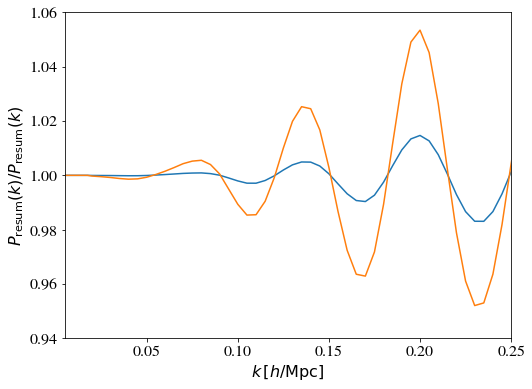

In [43]:
plt.figure()

plt.plot(common.k, resumPs[0]/noresumPs[0], 'C0-', label = 'mono')
plt.plot(common.k, resumPs[1]/noresumPs[1], 'C1-', label = 'quad')

plt.xlim(0.005, 0.25)
plt.ylim(0.94, 1.06)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_{\rm resum}(k)/P_{\rm resum}(k)$')

plt.show()

## Nonlinear power spectrum II: unspecified EFT parameters

The power spectrum can also be computed without specifying the EFT parameters. This is interesting for subsampling them or to marginalize over the ones that appear only linearly in the power spectrum.

In [44]:
time1 = time.time()
raven = pybird.Bird(kk, Pk, f, DA, H, zpk, which='all', co=common)
nonlinear.PsCf(raven)
raven.setPsCfl()
resum.Ps(raven)
print(time.time() - time1)

1.3937718868255615


The terms are given as follow:

In [45]:
b1, b2, b3, b4, b5, b6, b7 = bs
f = raven.f
b11 = np.array([ b1**2, 2.*b1*f, f**2 ])
bct = np.array([ 2.*b1*b5, 2.*b1*b6, 2.*b1*b7, 2.*f*b5, 2.*f*b6, 2.*f*b7 ])
bloop = np.array([ 1., b1, b2, b3, b4, b1*b1, b1*b2, b1*b3, b1*b4, b2*b2, b2*b4, b4*b4 ])
lin = np.einsum('b,lbx->lx', b11, raven.P11l)
loop = np.einsum('b,lbx->lx', bloop, raven.Ploopl) 
counterterm = np.einsum('b,lbx->lx', bct, raven.Pctl)
ravenPs = lin + loop + counterterm

The above is equivalent to the building function:

In [46]:
raven.setreducePslb(bs)

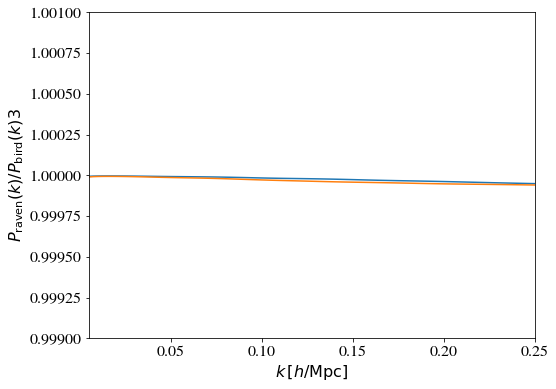

In [47]:
plt.figure()

plt.plot(common.k, raven.fullPs[0]/bird.fullPs[0], 'C0', label = 'mono')
plt.plot(common.k, raven.fullPs[1]/bird.fullPs[1], 'C1', label = 'quad')

plt.xlim(0.005, 0.25)
plt.ylim(1-.001, 1+.001)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$ P_{\rm raven}(k) / P_{\rm bird}(k)3$')

plt.show()

Here are plotted various contributions to the power spectrum:

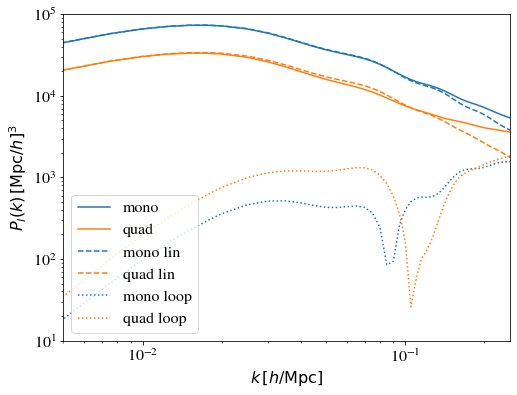

In [48]:
plt.figure()

plt.loglog(common.k, ravenPs[0], 'C0', label = 'mono')
plt.loglog(common.k, ravenPs[1], 'C1', label = 'quad')

plt.loglog(common.k, lin[0], 'C0--', label = 'mono lin')
plt.loglog(common.k, lin[1], 'C1--', label = 'quad lin')

plt.loglog(common.k, np.abs(loop[0]+counterterm[0]), 'C0:', label = 'mono loop')
plt.loglog(common.k, np.abs(loop[1]+counterterm[1]), 'C1:', label = 'quad loop')

plt.xlim(0.005, 0.25)
plt.ylim(10, 1e5)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.legend(loc='lower left')

plt.show()

## Projection on the sky

Finally, set the AP effect and interpolate on the k-array of the data

In [49]:
projection.AP(bird)
projection.kdata(bird)

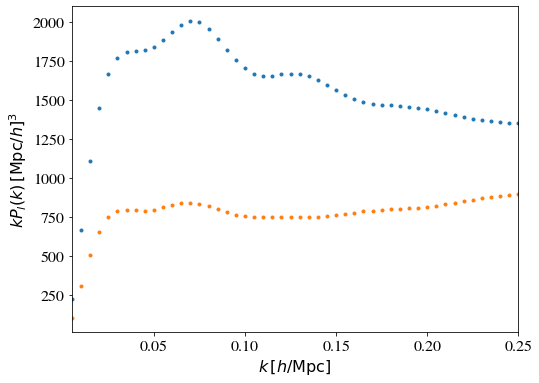

In [50]:
plt.figure()

plt.plot(kdata, kdata * bird.fullPs[0], 'C0.', label = 'mono')
plt.plot(kdata, kdata * bird.fullPs[1], 'C1.', label = 'quad')

plt.xlim(0.005, 0.25)

plt.xlabel(r'$k \, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$k P_l(k) \, [\mathrm{Mpc}/h]^3$')

plt.show()

Let us apply the window function now as convolution in Fourier space. First we redefine the projection class to include the mask. It will load precomputed Fourier convolution mask if it is in the folder, otherwise it will compute a new one from a provided mask in configuration space.

In [55]:
projection = pybird.Projection(kdata, pybird.DA(Om_AP, z_AP), pybird.Hubble(Om_AP,z_AP), co=common,
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', 
    path_to_window='./montepython_tree/data/pybird/Window',
    window_configspace_file='./montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z057.dat')

Loaded mask: ./montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl2_kmax0.30.npy


Here is a masked bird

In [56]:
plover = pybird.Bird(kk, Pk, f, DA, H, zpk, which='full', co=common)
nonlinear.PsCf(plover)
plover.setPsCf(bs)
resum.Ps(plover)
projection.AP(plover)
projection.Window(plover)
projection.kdata(plover)

(0.005, 0.25)

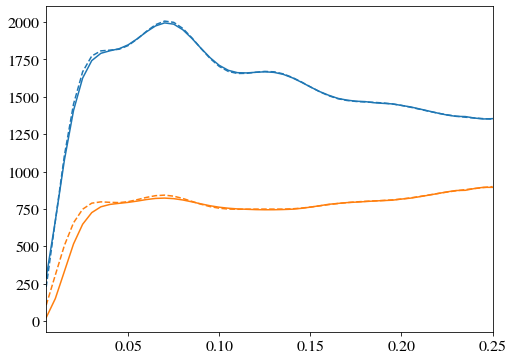

In [57]:
plt.plot(kdata, kdata*plover.fullPs[0], 'C0-')
plt.plot(kdata, kdata*plover.fullPs[1], 'C1-')
plt.plot(kdata, kdata*bird.fullPs[0], 'C0--')
plt.plot(kdata, kdata*bird.fullPs[1], 'C1--')
plt.xlim(0.005, 0.25)

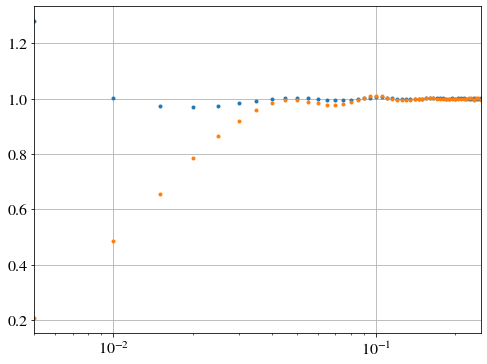

In [58]:
plt.plot(kdata, plover.fullPs[0]/bird.fullPs[0], 'C0.')
plt.plot(kdata, plover.fullPs[1]/bird.fullPs[1], 'C1.')
plt.grid()
plt.xlim(0.005, 0.25)
plt.xscale('log')

## Hexadecapole

PyBird can compute the hexadecapole. First we redefine the PyBird classes to include the hexadecapole. In particular, we set Nl=3 in the Common() class.

In [60]:
commonhex = pybird.Common(Nl=3, kmax=kmax, optiresum=True)
nonlinear = pybird.NonLinear(load=True, save=True, co=commonhex)
resum = pybird.Resum(co=commonhex)
projection = pybird.Projection(kdata, pybird.DA(Om_AP, z_AP), pybird.Hubble(Om_AP,z_AP), co=commonhex,
    window_fourier_name='pynest_BOSS_CMASS_NGC_z057', 
    path_to_window='./montepython_tree/data/pybird/Window',
    window_configspace_file='./montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z057.dat')

Can't load mask: ./montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy 
 instead,
Computing new mask.
Saving mask: ./montepython_tree/data/pybird/Window/pynest_BOSS_CMASS_NGC_z057_Nl3_kmax0.30.npy


Here is the bird up to the hexadecapole

In [61]:
birdhex = pybird.Bird(kk, Pk, f, DA, H, zpk, which='full', co=commonhex)
nonlinear.PsCf(birdhex)
birdhex.setPsCf(bs)
resum.Ps(birdhex)
projection.AP(birdhex)
projection.Window(birdhex)
projection.kdata(birdhex)

(0.005, 0.25)

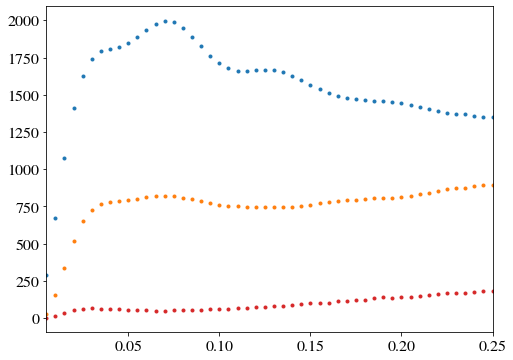

In [62]:
plt.plot(kdata, kdata*birdhex.fullPs[0], 'C0.')
plt.plot(kdata, kdata*birdhex.fullPs[1], 'C1.')
plt.plot(kdata, kdata*birdhex.fullPs[2], 'C3.')
plt.xlim(0.005, 0.25)

## Correlation function

PyBird can compute the correlation function multipole. 
We redefine the PyBird classes to include the correlation function multipole. In particular, we set smax=1000 (in Mpc/h) in the Common() class. 

As the resummation is first performed in Fourier space then the IR corrections are spherical Bessel transform to configuration space, enabling the correlation function automatically redefine kmax = 0.5 (h/Mpc) such that the BAO peak will be fully resummed.

In [96]:
from importlib import reload
reload(pybird)

sdata = np.linspace(25., 500., 100)

commoncf = pybird.Common(Nl=3, smax=1000., optiresum=True)
nonlinear = pybird.NonLinear(load=True, save=False, co=commoncf)
resum = pybird.Resum(co=commoncf)
projection = pybird.Projection(sdata, pybird.DA(Om_AP, z_AP), pybird.Hubble(Om_AP,z_AP), co=commoncf, cf=True, 
    window_configspace_file='./montepython_tree/data/pybird/Window/window_BOSS_CMASS_NGC_z057.dat')


/Volumes/Work/UQ/DESI/cBIRD/pybird/pybird/pybird.py:715: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.co.Nk is not 0:
/Volumes/Work/UQ/DESI/cBIRD/pybird/pybird/pybird.py:840: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.co.Nk is not 0:
/Volumes/Work/UQ/DESI/cBIRD/pybird/pybird/pybird.py:971: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if window is 1:
/Volumes/Work/UQ/DESI/cBIRD/pybird/pybird/pybird.py:1051: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if extrap is "extrap":
/Volumes/Work/UQ/DESI/cBIRD/pybird/pybird/pybird.py:1069: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif extrap is "padding":
/Volumes/Work/UQ/DESI/cBIRD/pybird/pybird/pybird.py:1554: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if which is "8loop":
/Volumes/Work/UQ/DESI/cBIRD/pybird/pybird/pybird.py:1556: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif which is "12loop":
/Volumes/Work/UQ/DESI/cBIRD/pybi

In [97]:
magpie = pybird.Bird(kk, Pk, f, DA, H, zpk, which='full', co=commoncf)
nonlinear.PsCf(magpie)
magpie.setPsCf(bs)
noresumCf = np.copy(magpie.fullCf)
resum.PsCf(magpie)
resumCf = np.copy(magpie.fullCf)
projection.AP(magpie)
projection.Window(magpie)
projection.kdata(magpie)

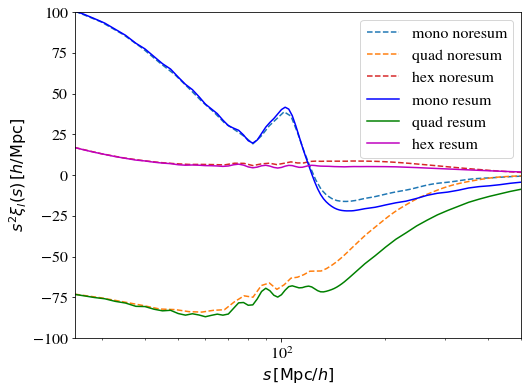

In [98]:
plt.figure()

plt.plot(sdata, sdata**2 * magpie.fullCf[0], 'C0--', label = 'mono noresum')
plt.plot(sdata, sdata**2 * magpie.fullCf[1], 'C1--', label = 'quad noresum')
plt.plot(sdata, sdata**2 * magpie.fullCf[2], 'C3--', label = 'hex noresum')

plt.plot(commoncf.s, commoncf.s**2 * resumCf[0], 'b-', label = 'mono resum')
plt.plot(commoncf.s, commoncf.s**2 * resumCf[1], 'g-', label = 'quad resum')
plt.plot(commoncf.s, commoncf.s**2 * resumCf[2], 'm-', label = 'hex resum')

plt.xscale('log')
plt.xlim(25., 500.)
plt.ylim(-100., 100.)
plt.xlabel(r'$s \, [\mathrm{Mpc}/h]$')
plt.ylabel(r'$s^2 \xi_l(s) \, [h/\mathrm{Mpc}]$')

plt.legend()

plt.show()

Again, the correlation function can be evaluated without specifying the EFT parameters

In [94]:
treepie = pybird.Bird(kk, Pk, f, DA, H, zpk, which='all', co=commoncf)
nonlinear.PsCf(treepie)
treepie.setPsCfl()
resum.PsCf(treepie)
projection.AP(treepie)
projection.Window(treepie)
projection.kdata(treepie)

treepie.setreduceCflb(bs)

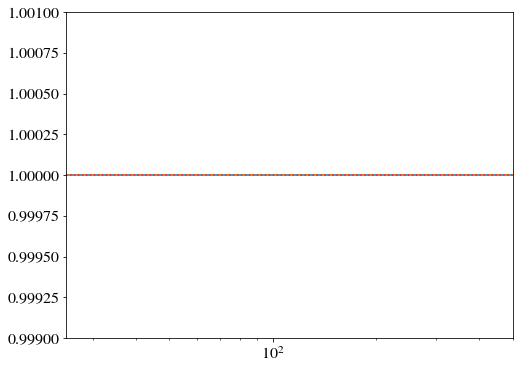

In [95]:
plt.figure()

plt.plot(sdata, treepie.fullCf[0]/magpie.fullCf[0], 'C0-', label = 'mono')
plt.plot(sdata, treepie.fullCf[1]/magpie.fullCf[1], 'C1--', label = 'quad')
plt.plot(sdata, treepie.fullCf[2]/magpie.fullCf[2], 'C3:', label = 'hex')
plt.xlim(25., 500.)
plt.xscale('log')
plt.ylim(1-.001, 1+.001)

plt.show()